Preprocessing in ```scripts/20210108a-CD34-ATAC-multiome-ArchR-preprocessing.R```

In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

In [2]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [4]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [5]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

# Load data

## ATAC

In [6]:
data_dir = os.path.expanduser('~/projects/metacells/data/CD34/Multiome/ArchR/cd34_multiome_atac/export/')

### Peaks data

In [7]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/projects/metacells/data/CD34/Multiome/ArchR/cd34_multiome_atac/export/peak_counts/counts.mtx'

In [8]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx
chr1:816070-816570,chr1,816070,816570,501,*,22.29089,0.630,0.443,2,C13._.cd34_multiome_rep2,FAM87B,1051,Promoter,1050,uc057aum.1,0.2894,1
chr1:817092-817592,chr1,817092,817592,501,*,81.21551,0.909,0.863,2,C13._.cd34_multiome_rep1,FAM87B,29,Promoter,28,uc057aum.1,0.4790,2
chr1:827266-827766,chr1,827266,827766,501,*,21.71270,0.974,0.903,2,C12._.cd34_multiome_rep1,LINC01128,2378,Promoter,5,uc057auo.1,0.6926,3
chr1:838271-838771,chr1,838271,838771,501,*,51.67031,0.858,0.776,2,C1._.cd34_multiome_rep2,LINC01128,13383,Intronic,6915,uc057auo.1,0.4611,4
chr1:842638-843138,chr1,842638,843138,501,*,13.77630,0.628,0.418,2,C1._.cd34_multiome_rep2,LINC01128,17750,Intronic,8459,uc057auo.1,0.5689,5


In [9]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

In [10]:
ad.X = ad.X.tocsr()

In [11]:
ad

AnnData object with n_obs × n_vars = 6881 × 246113
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'

### SVD

In [12]:
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

### Metadata

In [13]:
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [14]:
ad

AnnData object with n_obs × n_vars = 6881 × 246113
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    obsm: 'X_svd'

### Gene scores

In [15]:
# Gene scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

In [16]:
ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values

In [17]:
ad

AnnData object with n_obs × n_vars = 6881 × 246113
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'GeneScores'

# Preprocessing

In [18]:
# Leiden and UMAP
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
warnings.filterwarnings('default')

In [19]:
# Phenograph
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_svd'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.6359975337982178 seconds
Jaccard graph constructed in 1.4641332626342773 seconds
Wrote graph to binary file in 0.8439812660217285 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.822714
After 2 runs, maximum modularity is Q = 0.826209
After 18 runs, maximum modularity is Q = 0.82771
Louvain completed 38 runs in 8.218618869781494 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 12.544304609298706 seconds


In [20]:
# Diffusion maps
warnings.filterwarnings('ignore')
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_svd'], index=ad.obs_names))
warnings.filterwarnings('default')
ad.obsp['DM_kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors']  = dm_res['EigenVectors'].values
ad.uns['DM_EigenValues']  = dm_res['EigenValues'].values

Determing nearest neighbor graph...


In [21]:
# Force directed layout
ad.obsm['X_FDL'] = harmony.plot.force_directed_layout(dm_res['kernel']).values

100%|██████████| 500/500 [00:46<00:00, 10.67it/s]

BarnesHut Approximation  took  20.78  seconds
Repulsion forces  took  22.26  seconds
Gravitational forces  took  0.15  seconds
Attraction forces  took  1.31  seconds
AdjustSpeedAndApplyForces step  took  0.95  seconds


# Visualizations

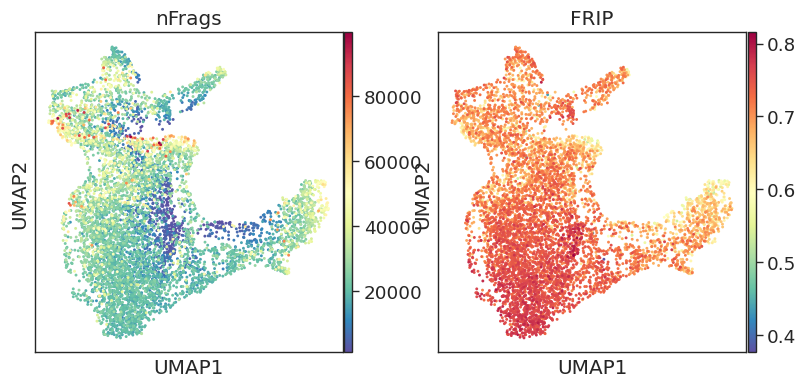

In [9]:
sc.pl.scatter(ad, basis='umap', color=['nFrags', 'FRIP'])

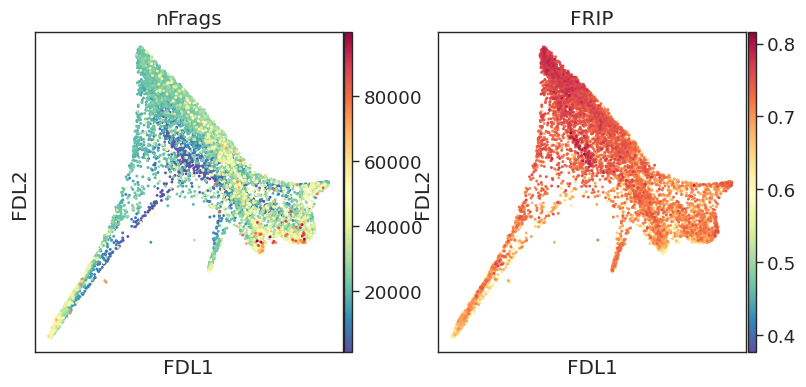

In [10]:
sc.pl.scatter(ad, basis='FDL', color=['nFrags', 'FRIP'])

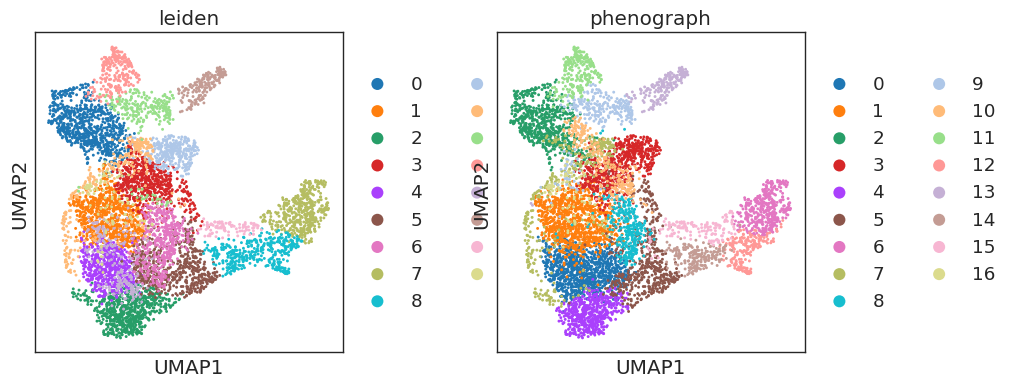

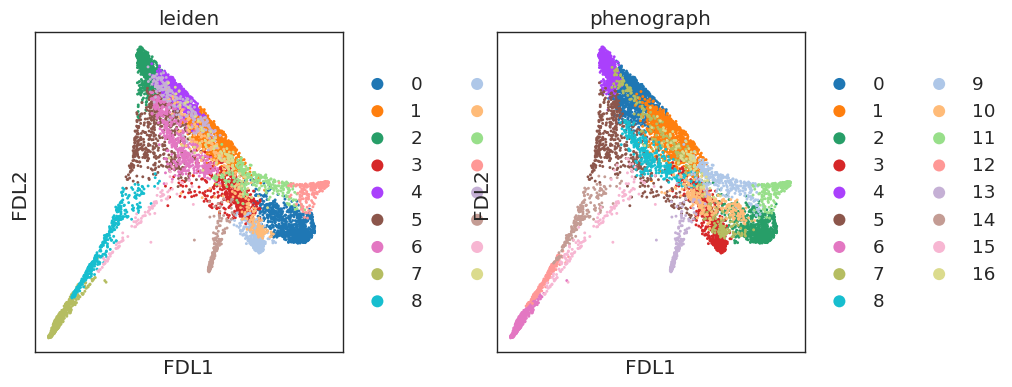

In [11]:
sc.pl.scatter(ad, basis='umap', color=['leiden', 'phenograph'])
sc.pl.scatter(ad, basis='FDL', color=['leiden', 'phenograph'])

# Comparison to RNA

In [12]:
rna_ad = sc.read(data_dir + '../../../cd34_multiome_rna_no_bcells.h5ad')

In [26]:
ad.obs['celltype'] = rna_ad.obs['celltype'][ad.obs_names].astype(str).values
ad.obs['rnaPhenograph']  = rna_ad.obs['phenograph'][ad.obs_names].values
ad.obs['rnaLeiden']  = rna_ad.obs['leiden'][ad.obs_names].values

# ad.uns['celltype_colors'] = rna_ad.uns['celltype_colors']

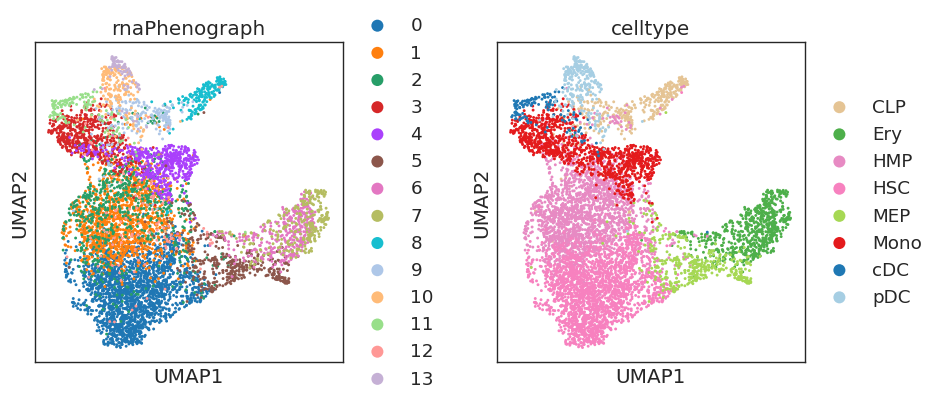

In [13]:
sc.pl.scatter(ad, basis='umap', color=['rnaPhenograph', 'celltype'])

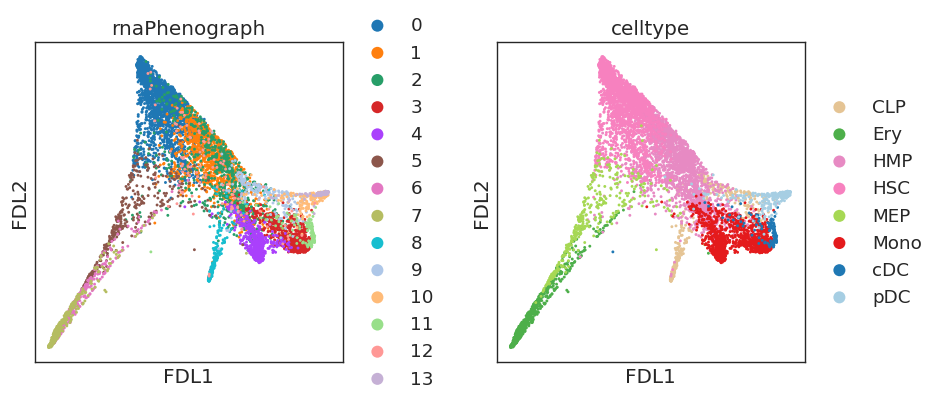

In [14]:
sc.pl.scatter(ad, basis='FDL', color=['rnaPhenograph', 'celltype'])

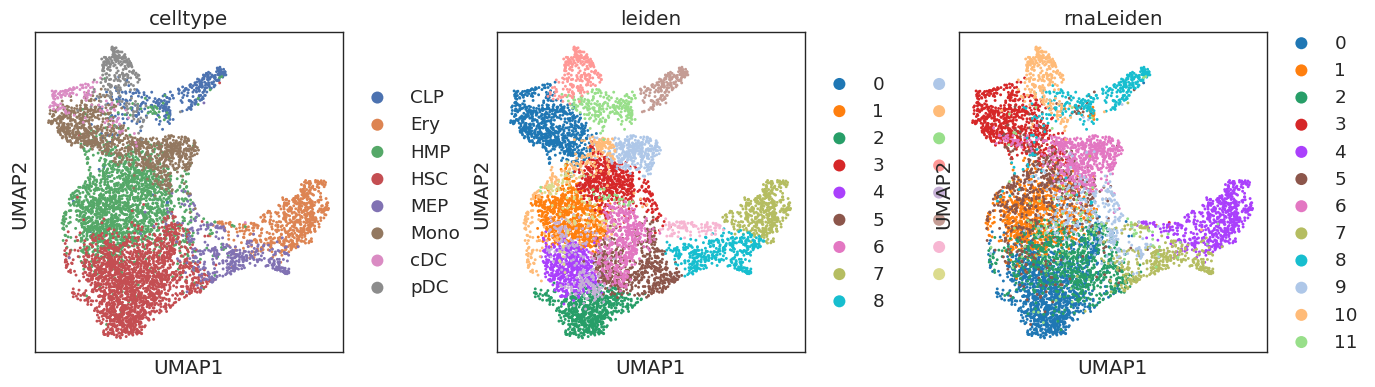

In [29]:
sc.pl.scatter(ad, basis='umap', color=['celltype', 'leiden', 'rnaLeiden'])

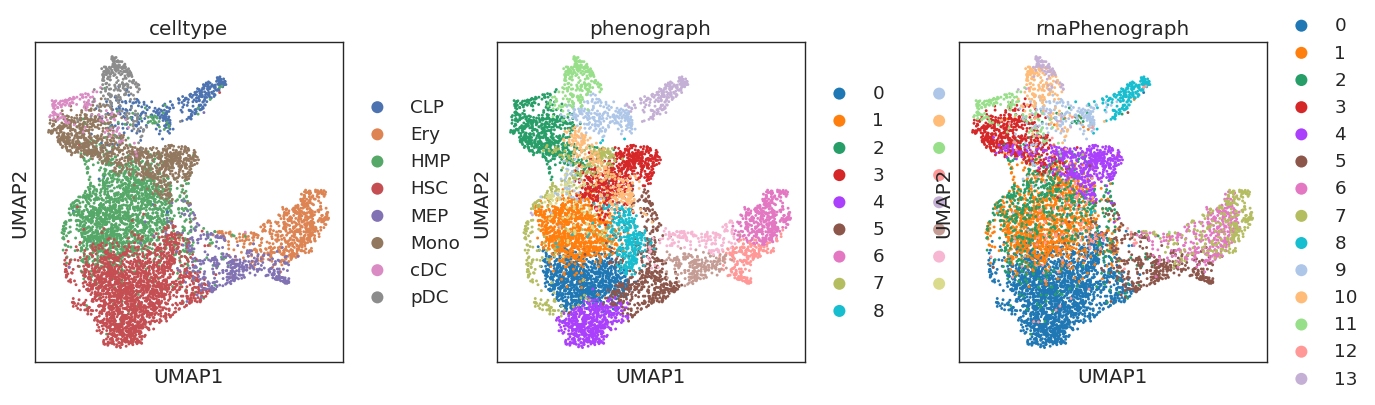

In [38]:
sc.pl.scatter(ad, basis='umap', color=['celltype', 'phenograph', 'rnaPhenograph'])

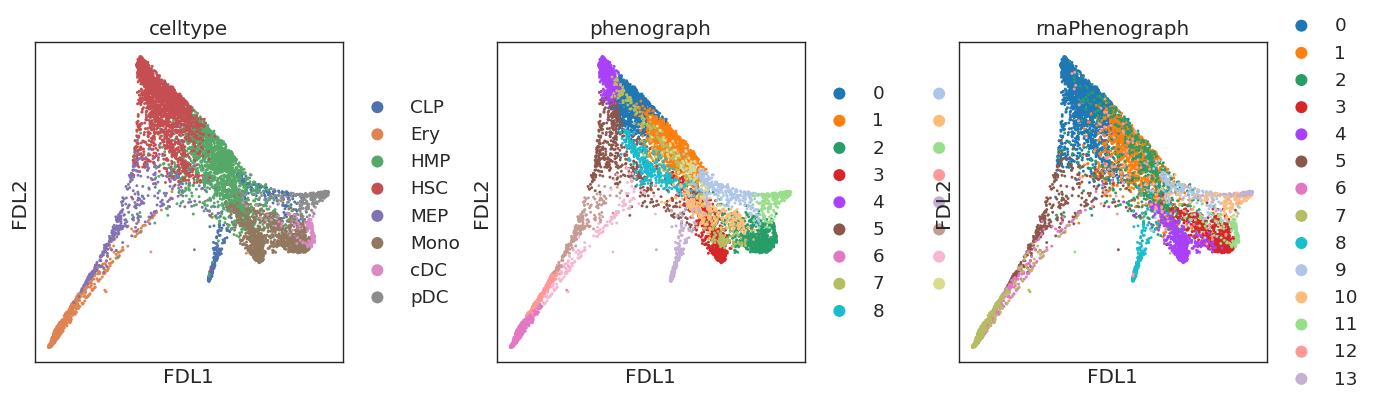

In [39]:
sc.pl.scatter(ad, basis='FDL', color=['celltype', 'phenograph', 'rnaPhenograph'])

## Cluster comparison

In [15]:
atac_obs = 'leiden'
rna_obs = 'celltype'

rna_by_atac = pd.DataFrame(0.0, index='RNA:' + rna_ad.obs[rna_obs].values.categories, 
                          columns='ATAC:' + ad.obs[atac_obs].values.categories)
for c in rna_by_atac.columns:
    # Cells 
    cells = ad.obs_names['ATAC:' + ad.obs[atac_obs].astype(str) == c]
    
    # Proportions
    proportions = rna_ad.obs[rna_obs][cells].value_counts() / len(cells)
    proportions.index = 'RNA:' + proportions.index.astype(str)
    rna_by_atac.loc[proportions.index, c] = proportions

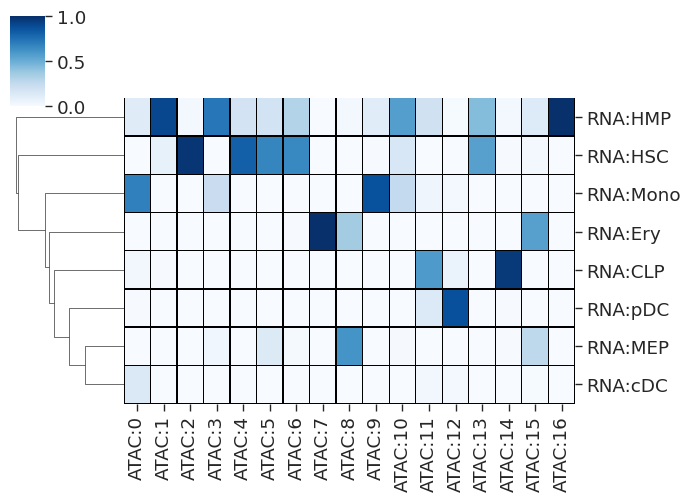

In [16]:
sns.clustermap(rna_by_atac, cmap=matplotlib.cm.Blues, vmin=0, vmax=1, 
               figsize=[7, 5], linecolor='black', linewidth=0.25, 
               row_cluster=True, col_cluster=False, 
               xticklabels=rna_by_atac.columns, yticklabels=rna_by_atac.index)

## Diffusion map comparison

In [17]:
rna_ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'Metacell'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DMEigenValues', 'celltype_colors', 'ct_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'phenograph_colors', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'connectivities', 'distances'

In [18]:
ct_colors = pd.Series(sns.color_palette(rna_ad.uns['celltype_colors']).as_hex(), 
                     index=rna_ad.obs['celltype'].values.categories)
ct_colors

CLP     #e5c494
Ery     #4daf4a
HMP     #e78ac3
HSC     #f781bf
MEP     #a6d854
Mono    #e41a1c
cDC     #1f78b4
pDC     #a6cee3
dtype: object

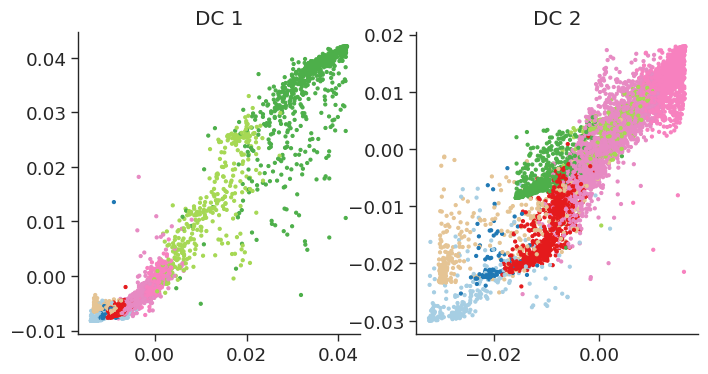

In [22]:
n_comps = 2

fig = palantir.plot.FigureGrid(n_comps, n_comps, scale=4)

for c, ax in enumerate(fig):
    ax.scatter(rna_ad[ad.obs_names, :].obsm['DM_EigenVectors'][:, c + 1], 
              ad.obsm['DM_EigenVectors'][:, c + 1], 
              s=5, color=ct_colors[ad.obs['celltype']])
    ax.set_title(f'DC {c+1}')
sns.despine()

# Save

In [35]:
ad

AnnData object with n_obs × n_vars = 6881 × 246113
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'rnaPhenograph', 'rnaLeiden'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'GeneScoresColums', 'neighbors', 'umap', 'leiden', 'DM_EigenValues', 'leiden_colors', 'phenograph_colors', 'rnaPhenograph_colors', 'celltype_colors', 'rnaLeiden_colors'
    obsm: 'X_svd', 'GeneScores', 'X_umap', 'DM_EigenVectors', 'X_FDL'
    obsp: 'distances', 'connectivities', 'DM_kernel'

In [36]:
ad.write(data_dir + '../../../cd34_multiome_atac_no_bcells.h5ad')

## Clean up

In [37]:
!rm -rf $data_dir/gene_scores.csv
!rm -rf $data_dir/peak_counts/counts.mtx
!rm -rf $data_dir/../GroupCoverages

# SCRATCH

In [8]:
ad = sc.read(data_dir + '../../../cd34_multiome_atac_no_bcells.h5ad')

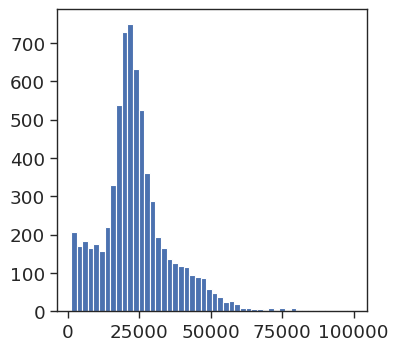

In [12]:
plt.hist(ad.obs['FRIP'], 50);